# Shape Detection
The following Notebook intends to take a look at the detection of a variable number of bounding boxes that delimit objects in an image dataset. The structure of this experiment is as follows:

* Premise
* Dataset generation
* Dataset Analysis and preprocessing
* Modeling Training phase
* Prediction analysis
* Conclusions

## Premise

(tags: CNN, Object detection)

This work was inspired by [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning).

Rieke's work is interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the example's targets label between one epoch and another. A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (on each epoch all the predictions of the network with the target values are compared and could be swapped).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every epoch the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import cv2
import tensorflow as tf
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from keras import optimizers
import pickle

from sd_utils import create_dataset, order_bb, euc_loss, rmse, IoU, mean_IoU, visualize, visual_metric

%matplotlib inline

Using TensorFlow backend.


## Dataset Generation
We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
N_imgs = 100000

# imagines side dimension
side_dim = 32 

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 

# color thresholds
min_threshold = 0
max_threshold = 128

# confidence threshold
Pc_th = .9 # to implement in future

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))

# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

In [0]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = create_dataset(N_imgs, 
                                                N_bb, 
                                                side_dim, 
                                                obj_min_dim, 
                                                obj_max_dim, 
                                                min_threshold, 
                                                max_threshold)

## Dataset Analysis and Preprocessing
First we analyze our datasets and start preprocessing them

In [5]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (100000, 32, 32, 3)
Dimension of BBoxes array: (100000, 4, 5)
Dimension of distance array: (100000, 4)


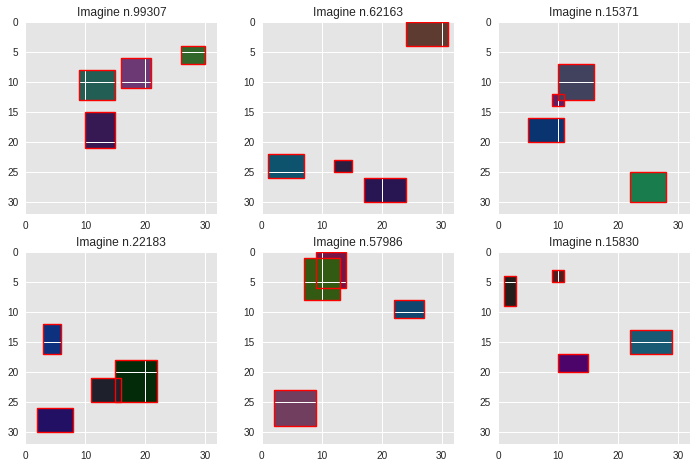

In [6]:
# We take to observe n_visual random images of our dataset and the relative bounding boxes 
n_visual = 6
rand_ims = np.zeros((n_visual,), dtype=int)

fig = plt.figure(figsize=(12,12))
for i in range (n_visual):
  
  # We take a random image of our training set
  im = np.random.randint(N_imgs)
  rand_ims[i] = im
  ax = fig.add_subplot((n_visual//3)+1,3, i+1)
  ax.set_title('Imagine n.' + str(im))
  visualize(imgs[im], None, bounding_boxes[im], None, 0)
plt.show()

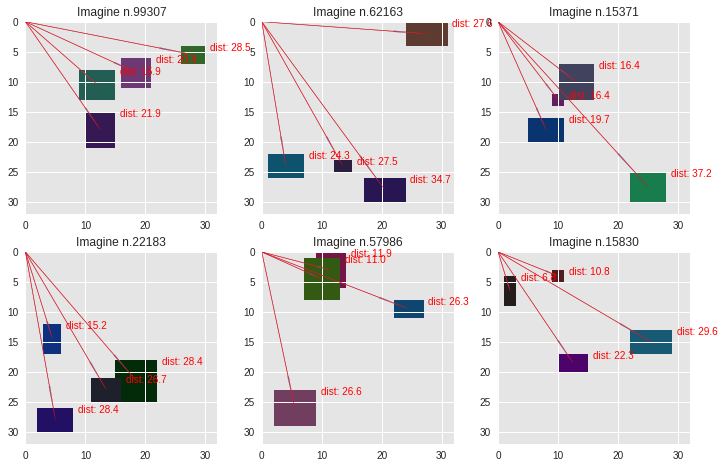

In [7]:
# We look at the images again, this time highlighting the distance of the objects from the origin ...
fig = plt.figure(figsize=(12,12))

for i in range(n_visual):
  im = rand_ims[i]
  ax = fig.add_subplot((n_visual//3)+1,3, i+1)
  ax.set_title('Imagine n.' + str(im))
  visualize(imgs[im], distance[im], bounding_boxes[im], None, 0)
  
plt.show()


We reordered every bounding boxes of an image based on the correspondent object distance from the origin of axes. <br/>This to avoid the problem highlighted by Rieke's article.

In [0]:
bb_ordered = order_bb(bounding_boxes, distance) 

### Let's start thinking in terms of Machine Learning.  <br/>
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.

In [9]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
print('X shape: ',X.shape, '---- Average value: ', np.mean(imgs), '---- Standard deviation:', np.std(imgs))

Y = bb_ordered.reshape(N_imgs, -1) 
print('Y shape: ',Y.shape)

X shape:  (100000, 32, 32, 3) ---- Average value:  0.8504064790390119 ---- Standard deviation: 0.17724984702422514
Y shape:  (100000, 20)


Below we see the shape of our X values and we observe one of our Y target values.

In [10]:
print('Images example', i, 'has shape:\n', X[im].shape, '\n')
print('...and the target values Y are:\n', Y[im])

Images example 5 has shape:
 (32, 32, 3) 

...and the target values Y are:
 [ 1.  1.  4.  2.  5.  1.  9.  3.  2.  2.  1. 10. 17.  5.  3.  1. 22. 13.
  7.  4.]


We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 70%, 15%, 15%.

In [11]:
i = int(0.7 * N_imgs)
j = int(0.15 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_val = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(70000, 32, 32, 3) (70000, 20) (15000, 32, 32, 3) (15000, 20) (15000, 32, 32, 3) (15000, 20)


## Modeling Training phase
###The Neural Network
In previous experiments, we used the network proposed in Rieke's experiment, following the fundamental suggestion of Andrew Ng to implement a model as soon as possible to have a starting point on which to base. Now let's start working on network tuning and try to improve its rather poor performance. The model we use is clearly inspired by the [AlexNet](https://en.wikipedia.org/wiki/AlexNet). It uses two pairs of CNN-MaxPooling layers followed, three other CNN and two fully connected layers, for a total of about 1.397 thousand parameters.

In [12]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(384, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.1))
model.add(BatchNormalization())
model.add(Dense(N_bb*5))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         98432     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         98496     
__________


As optimization algorithm we use Adadelta, and as loss function we will Root Mean Squared Error (Rmse) which has proven to provide better performance than the Rse and the Euclidean Distance.

Let's start with a cycle of N_ep epochs:

In [0]:
N_ep = 100
init_ep = 0 
Batchs = 128
optimizer = 'adadelta'
loss = rmse 

In [14]:
model.compile(optimizer, loss)
history = model.fit(X_train, 
                    Y_train, 
                    epochs=N_ep, 
                    validation_data=(X_val, Y_val), 
                    batch_size=Batchs, 
                    initial_epoch = init_ep, 
                    verbose=1)

Train on 70000 samples, validate on 15000 samples
Epoch 1/100
70000/70000 [==============================] - 28s 403us/step - loss: 3.0489 - val_loss: 2.0376
Epoch 2/100
70000/70000 [==============================] - 26s 367us/step - loss: 1.8308 - val_loss: 1.6327
Epoch 3/100
70000/70000 [==============================] - 24s 347us/step - loss: 1.6168 - val_loss: 1.4739
Epoch 4/100
70000/70000 [==============================] - 25s 353us/step - loss: 1.4806 - val_loss: 1.3525
Epoch 5/100
70000/70000 [==============================] - 25s 361us/step - loss: 1.3797 - val_loss: 1.3068
Epoch 6/100
70000/70000 [==============================] - 26s 368us/step - loss: 1.3026 - val_loss: 1.2522
Epoch 7/100
70000/70000 [==============================] - 26s 377us/step - loss: 1.2387 - val_loss: 1.1650
Epoch 8/100
70000/70000 [==============================] - 27s 382us/step - loss: 1.1947 - val_loss: 1.1367
Epoch 9/100
70000/70000 [==============================] - 25s 361us/step - loss: 1.14

##Prediction Analysis
We evaluate the results obtained. We use the Validation Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - error loss.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 (or 0 -100% as percentage) and the closer they are to 1 (100%), the more the area of our predictions approaches that of the correct bounding boxes.

But first let's take a look at our predictions. We will consider as valid Bounding Boxes only those that exceed a certain threshold of IoU (.5 or 50%)

In [0]:
# The predictions of the neural network using our Validation set as input
pred_bboxes = model.predict(X_val)
pred_bboxes = pred_bboxes.reshape(val_ex, N_bb, -1)

In [19]:
# And the expected bboxes of our Validation set
expe_bboxes = Y_val.reshape(val_ex, N_bb, -1)

# Their dimension
pred_bboxes.shape, expe_bboxes.shape

((15000, 4, 5), (15000, 4, 5))

| Image 10504 Object 1 |  Confidence: 0.997 |--- BBox IoU: 63.6% ---
| Image 10504 Object 2 |  Confidence: 0.997 |--- BBox IoU: 32.4% ---
| Image 10504 Object 3 |  Confidence: 0.997 |--- BBox IoU: 68.6% ---
| Image 10504 Object 4 |  Confidence: 0.997 |--- BBox IoU: 88.9% ---
| Image   301 Object 1 |  Confidence: 0.995 |--- BBox IoU: 69.0% ---
| Image   301 Object 2 |  Confidence: 0.995 |--- BBox IoU: 18.8% ---
| Image   301 Object 3 |  Confidence: 0.996 |--- BBox IoU: 72.9% ---
| Image   301 Object 4 |  Confidence: 0.995 |--- BBox IoU: 72.3% ---
| Image  7581 Object 1 |  Confidence: 0.996 |--- BBox IoU: 74.4% ---
| Image  7581 Object 2 |  Confidence: 0.996 |--- BBox IoU: 0.0% ---
| Image  7581 Object 3 |  Confidence: 0.996 |--- BBox IoU: 0.0% ---
| Image  7581 Object 4 |  Confidence: 0.995 |--- BBox IoU: 62.5% ---
| Image  2590 Object 1 |  Confidence: 0.997 |--- BBox IoU: 62.8% ---
| Image  2590 Object 2 |  Confidence: 0.997 |--- BBox IoU: 12.3% ---
| Image  2590 Object 3 |  Confidence

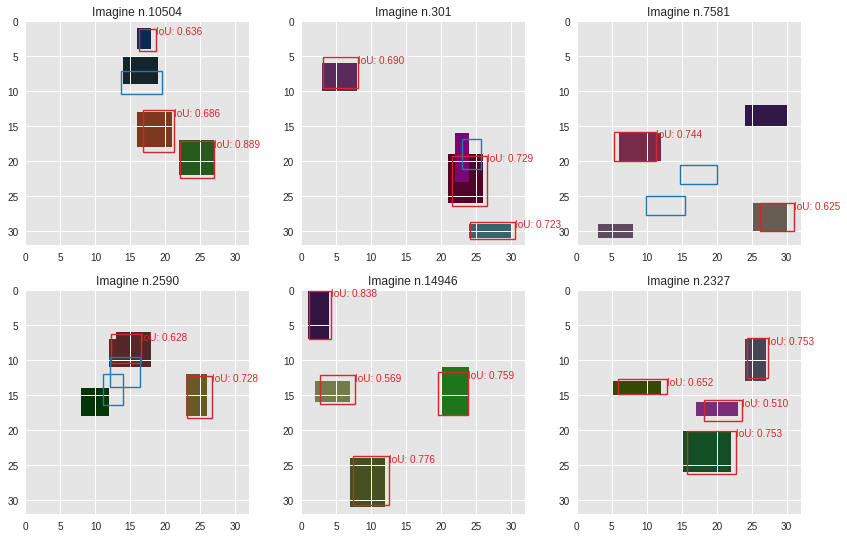

In [20]:
imgTest = (np.reshape(X_val, (val_ex, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .5

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 6
rand_ims = np.zeros((n_visual,), dtype=int)

fig = plt.figure(figsize=(14,14))
for i in range (n_visual):
  
  # We take a random image of our training set
  im = np.random.randint(X_val.shape[0])
  rand_ims[i] = im
  ax = fig.add_subplot((n_visual//3)+1,3, i+1)
  ax.set_title('Imagine n.' + str(im))
  visualize(imgTest[im], None, pred_bboxes[im], expe_bboxes[im], iou_tr)
plt.show()

### Evaluation of results
Now we evaluate the results, by calculating the average IoU for predictions on our Validation set. 
The graph below shows the learning curve (Euclidean Distance Loss for training and validation sets) for fifty epochs, with a network of 60 thousand examples using 128 mini-batch size.

Datatset mean IoU: 58.202190%
Final train loss: 0.8576037150382996
Final val loss: 0.7325684076445443
Dim. train: 70000 examples
Epochs: 100 - mini-batches: 128


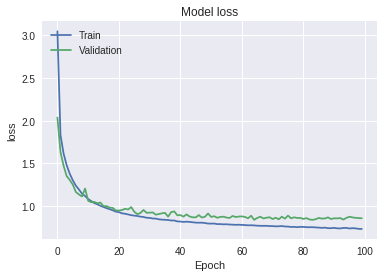

In [21]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

A final step before the conclusions is to verify that the metrics for the Validation set are aligned with the Test set. So we try to visualize some examples of predictions using the Test set and to calculate the average IoU for the whole test set.

In [22]:
# The predictions of the neural network using our Validation set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)
# And the expected bboxes of our Validation set
expe_bboxes = np.float32(Y_test.reshape(dim_val, N_bb, -1))

# Their dimension
pred_bboxes.shape, expe_bboxes.shape

((15000, 4, 5), (15000, 4, 5))

| Image  2086 Object 1 |  Confidence: 0.996 |--- BBox IoU: 72.1% ---
| Image  2086 Object 2 |  Confidence: 0.996 |--- BBox IoU: 65.9% ---
| Image  2086 Object 3 |  Confidence: 0.997 |--- BBox IoU: 56.3% ---
| Image  2086 Object 4 |  Confidence: 0.996 |--- BBox IoU: 59.8% ---
| Image  6468 Object 1 |  Confidence: 0.997 |--- BBox IoU: 64.6% ---
| Image  6468 Object 2 |  Confidence: 0.997 |--- BBox IoU: 63.7% ---
| Image  6468 Object 3 |  Confidence: 0.998 |--- BBox IoU: 16.2% ---
| Image  6468 Object 4 |  Confidence: 0.997 |--- BBox IoU: 75.8% ---
| Image   371 Object 1 |  Confidence: 0.996 |--- BBox IoU: 58.1% ---
| Image   371 Object 2 |  Confidence: 0.996 |--- BBox IoU: 59.1% ---
| Image   371 Object 3 |  Confidence: 0.997 |--- BBox IoU: 50.3% ---
| Image   371 Object 4 |  Confidence: 0.996 |--- BBox IoU: 60.8% ---
| Image  2871 Object 1 |  Confidence: 0.996 |--- BBox IoU: 74.3% ---
| Image  2871 Object 2 |  Confidence: 0.996 |--- BBox IoU: 76.1% ---
| Image  2871 Object 3 |  Confiden

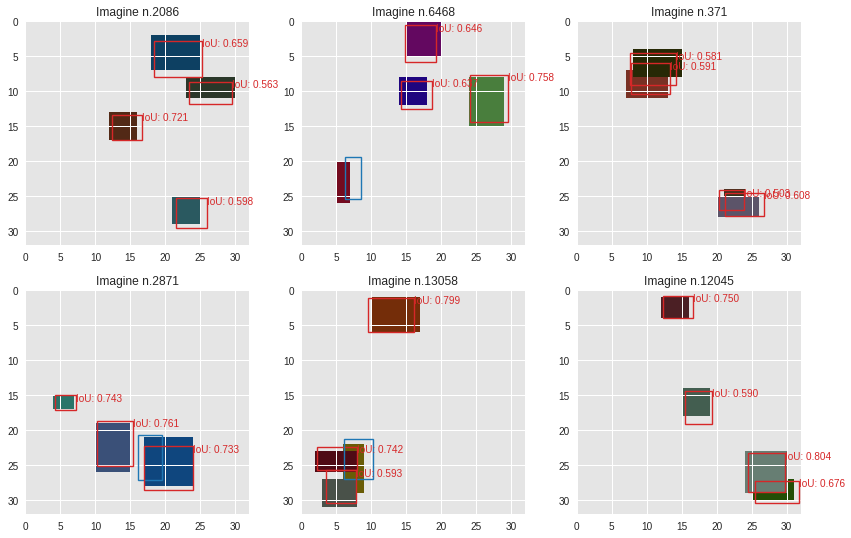

In [23]:
imgTest = (np.reshape(X_test, (val_ex, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .5

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 6
rand_ims = np.zeros((n_visual,), dtype=int)

fig = plt.figure(figsize=(14,14))
for i in range (n_visual):
  
  # We take a random image of our training set
  im = np.random.randint(X_test.shape[0])
  rand_ims[i] = im
  ax = fig.add_subplot((n_visual//3)+1,3, i+1)
  ax.set_title('Imagine n.' + str(im))
  visualize(imgTest[im], None, pred_bboxes[im], expe_bboxes[im], iou_tr)
plt.show()

In [24]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
print('The Test-set mean IoU is: ', m_iou)

The Test-set mean IoU is:  0.5813301437252235


## Some conclusion
The experiment shows the learning ability of the algorithm and the effectiveness of the solution we have adopted to avoid falling into the problem of undifferentiated bounding-boxes exposed by Rieke. In particular, it highlights the importance of pre-processing operations.

Compared to previous experiments we have improved the performance of our model. First of all, we have increased the depth of the network by taking inspiration from AlexNet. Secondly, we tried different loss functions and we opted for Rmse. The global validation set IoU has exceeded 58 points after 100 epochs. The predictions on the Test set confirm the results obtained.

Further experiments and improvements of the model are desirable: guidelines should provide for greater image complexity (and the use of different forms of objects), improved tuning in the training phase and a deep evaluation of the results, through Error Analysis and the use of other metrics (Precision and Recall).